
=== RandomForest — Holdout ===
Accuracy:  0.595
Precision: 0.337
Recall:    0.355
F1-score:  0.346
ROC-AUC:   0.549
PR-AUC:   0.331

Confusion matrix:
 [[12880  5561]
 [ 5131  2824]]

              precision    recall  f1-score   support

           0      0.715     0.698     0.707     18441
           1      0.337     0.355     0.346      7955

    accuracy                          0.595     26396
   macro avg      0.526     0.527     0.526     26396
weighted avg      0.601     0.595     0.598     26396

RF — CV ROC-AUC: 0.557 ± 0.002

Top 10 — RF Feature Importance Analysis:
 text_len     0.574646
title_len    0.259758
Country      0.052144
exp_month    0.031998
rev_month    0.031356
rev_year     0.025725
exp_year     0.024374
dtype: float64

=== DecisionTree(max_depth=6) — Holdout ===
Accuracy:  0.577
Precision: 0.368
Recall:    0.565
F1-score:  0.446
ROC-AUC:   0.606
PR-AUC:   0.375

Confusion matrix:
 [[10738  7703]
 [ 3462  4493]]

              precision    recall  f1-score   s

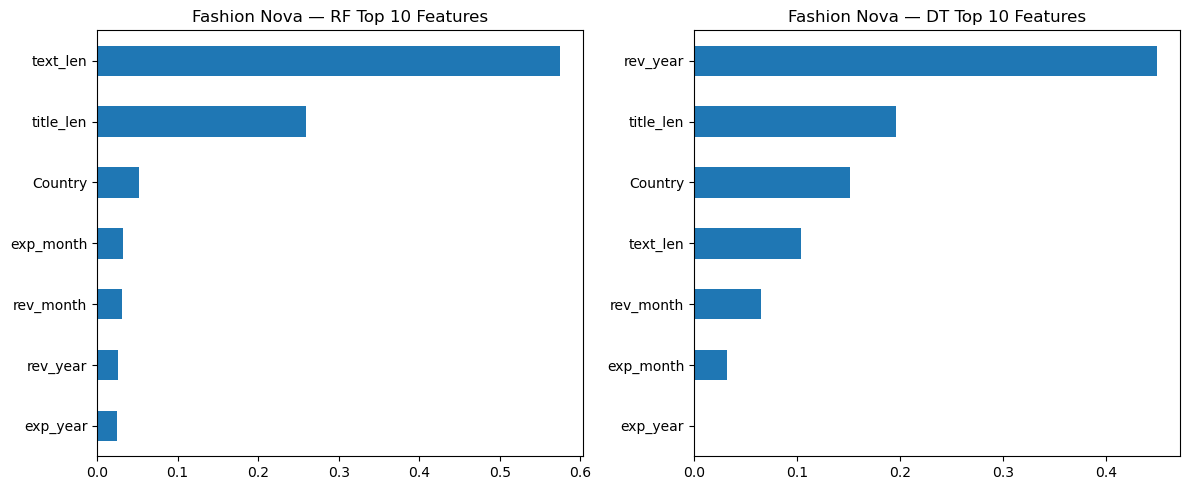

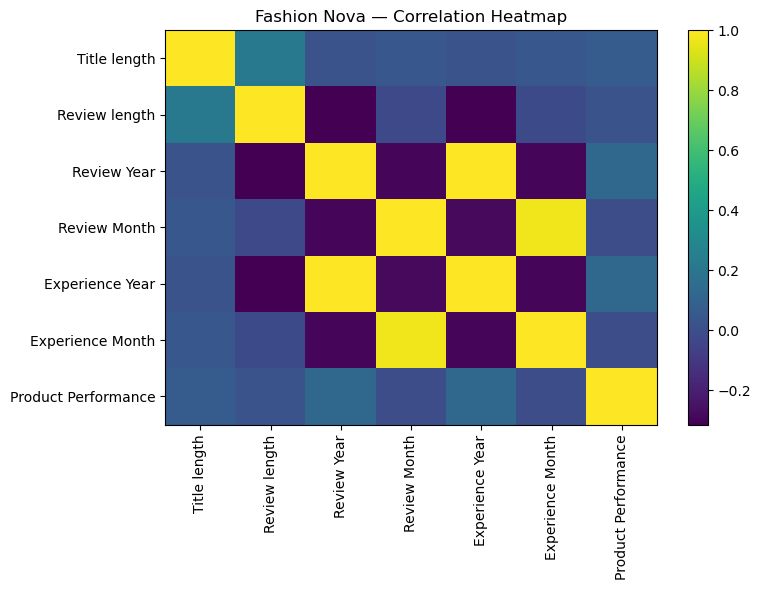

In [1]:
# ===================================Fashion Nova ===================================

# Importing the required libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# importing Scikit-learn libraries to split data, preprocess, build models and evaluate=ion.
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    average_precision_score
)

# The below code loads the dataset from the local system.
File_pathway = r"C:\\Users\\ROHIT PAUL\\Desktop\\Dissertation Dataset\\Fashion Nova Product Level.csv"
data_frame = pd.read_csv(File_pathway).dropna(axis=1, how="all").copy() # This line of the code reads the columns and drop the empty columns.

# If condition is being implemented which when triggered raises an error message.
if "Product Performance" not in data_frame.columns:
    raise ValueError("Expected 'Product Performance' (0/1).") 

# The below line ensures the target is a numeric 0/1.
y = pd.to_numeric(data_frame["Product Performance"], errors="coerce").fillna(0).astype(int)

# Feature Engineering.
if "Review Title" in data_frame.columns:
    data_frame["title_len"] = data_frame["Review Title"].astype(str).str.len() # This line of the code calcuates the length of each review title.
if "Review Text" in data_frame.columns:
    data_frame["text_len"]  = data_frame["Review Text"].astype(str).str.len() # This line of the code calcuates the length of each review text.

# In the below code, we are converting date-like fields to numeric values.
for src, dst in [("Review Year","rev_year"), ("Review Month","rev_month"),
                 ("Experience Year","exp_year"), ("Experience Month","exp_month")]:
    if src in data_frame.columns:
        data_frame[dst] = pd.to_numeric(data_frame[src], errors="coerce")

# In the below code, we are checking if country exists in the DataFrame.
# If country exists, it converts the values of the column into string data type.
if "Country" in data_frame.columns:
    data_frame["Country"] = data_frame["Country"].astype(str)


# Building predictors.
# If your label was built from Review Count / Rating / Sentiment Score, exclude them to avoid leakage.
v_blacklist = {"Review Count","Rating","Sentiment Score"}
var_skip_ids = re.compile(r"(id|sku|code|url|link|uuid|guid)", re.I) # This line of the code excludes the columns.

# The below piece of code filters out inappropriate columns.
# it collect the candidate feature columns.
candidates = []
for c in data_frame.columns:
    if c == "Product Performance": # This line skips the label columns.
        continue
    if c in v_blacklist: # This line excludes the blacklisted to avoid leakage.
        continue
    if var_skip_ids.search(c): # This line leverages regex pattern to exclude IDs/URLs.
        continue
    if data_frame[c].nunique(dropna=True) <= 1: # This piece of code excludes columns with unique value.
        continue
    candidates.append(c)

# In the below set of code, we select the best set of features for the model with a preferred order.
var_priority_features = ["Country","title_len","text_len","rev_year","rev_month","exp_year","exp_month"]
relevant = [c for c in var_priority_features if c in candidates] or candidates

# Input feature.
X = data_frame[relevant].copy()

# Train / test split + preprocessing
# In the below line of code, we are splitting the data into train (80%) and test (20%) while keeping class imbalance.. 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# The below codes identify column types on the training set (numerical or categorical).
numerical_columns = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

# Preprocessing.
preprocess = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), numerical_columns),
        ("cat", Pipeline([
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("enc", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
        ]), categorical_columns),
    ],
    remainder="drop"
)

# A method has been implemented to evaluate and print classification report and confusion metrics.
def report_metrics(name, y_true, y_pred, y_proba):
    v_accuracy  = accuracy_score(y_true, y_pred) # This line of the code evaluates the accuracy value of the model.
    v_precision = precision_score(y_true, y_pred, zero_division=0) # This line of the code evaluates the precision score of the model.
    v_recall  = recall_score(y_true, y_pred, zero_division=0) # This line of the code evaluates the recall score of the model.
    v_f1   = f1_score(y_true, y_pred, zero_division=0) # This line of the code evaluates the F1-score of the model.
    v_auc  = roc_auc_score(y_true, y_proba) # This line of the code evaluates the ROC-AUC value of the model.
    v_ap   = average_precision_score(y_true, y_proba) # This line of the code evaluates the PR-SUC value of the model.
   
    print(f"\n=== {name} — Holdout ===")
    print(f"Accuracy:  {v_accuracy:.3f}") # This line of the code prints the accuracy value of the model.
    print(f"Precision: {v_precision:.3f}") # This line of the code prints the precision score of the model.
    print(f"Recall:    {v_recall:.3f}") # This line of the code prints the recall score of the model.
    print(f"F1-score:  {v_f1:.3f}") # This line of the code prints the F1-score of the model.
    print(f"ROC-AUC:   {v_auc:.3f}") # This line of the code prints the ROC-AUC value of the model.
    print(f"PR-AUC:   {v_ap:.3f}") # This line of the code prints the PR-AUC value of the model.
    print() # Inserts an empty line.
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    print() # Inserts an empty line.
    print(classification_report(y_true, y_pred, digits=3, zero_division=0))

# 5-fold cross-validation setup.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Modelling the Random Forest Classifier.
random_forest = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=500, # This line of the code represents the number of trees.
        random_state=42, 
        class_weight="balanced_subsample", # This helps with the class imbalance.
        n_jobs=-1
    ))
])

random_forest.fit(X_train, y_train) # This line of the code trains the Random Forest model on the training set.
proba_random_forest = random_forest.predict_proba(X_test)[:, 1]
pred_random_forest  = (proba_random_forest >= 0.5).astype(int)
report_metrics("RandomForest", y_test, pred_random_forest, proba_random_forest) # This line prints evaluation on the test set.

va_cv_rf = cross_val_score(random_forest, X, y, cv=cv, scoring="roc_auc", n_jobs=-1) # This line of the code executes cross-validation for the RF model using ROC-AUC curve.
print("RF — CV ROC-AUC: %.3f ± %.3f" % (va_cv_rf.mean(),va_cv_rf.std())) # This line of the code prints the mean ROC-AUC score with the standard deviation of all folds.

# Evaluating the Feature Importances Analysis.
# A variable has been declared to combine the numerical and categorical columns into a single list.
list_columns = list(numerical_columns) + list(categorical_columns)
var_rf_imps_01 = pd.Series(random_forest.named_steps["clf"].feature_importances_, index=list_columns).sort_values(ascending=False)
print("\nTop 10 — RF Feature Importance Analysis:\n", var_rf_imps_01.head(10)) # This line of the code prints the top 10 most important feature importance.

# Building Decision Tree Classifier as the benchmark model.
decision_tree = Pipeline([
    ("prep", preprocess),
    ("clf", DecisionTreeClassifier(max_depth=6, random_state=42, class_weight="balanced"))
])
decision_tree.fit(X_train, y_train) # This line of the code trains the Deicion Tree model.
v_proba_dt = decision_tree.predict_proba(X_test)[:, 1] # This line of the code gets predicted probabilities for the positive class.
v_pred_dt  = (v_proba_dt >= 0.5).astype(int)
report_metrics("DecisionTree(max_depth=6)", y_test, v_pred_dt, v_proba_dt) # Displays the performance report for the Decision Tree model.

# The below block of the code cross-validates the ROC-AUC for the Decision Tree.
var_cv_dt = cross_val_score(decision_tree, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
print("DT — CV ROC-AUC: %.3f ± %.3f" % (var_cv_dt.mean(), var_cv_dt.std())) # This line prints the cross-validated ROC-AUC score for the Dt with mean and standard deviation.

# This block of the code evaluates the Feature Importance for the Decision Tree model.
var_dt_imps_01 = pd.Series(decision_tree.named_steps["clf"].feature_importances_, index=list_columns).sort_values(ascending=False)
print("\nTop 10 — DT Feature Importance Analysis:\n", var_dt_imps_01.head(10))

# Plottings Top-10 importances for both the models.
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) # This line of the code plots the figure.
var_rf_imps_01.head(10).iloc[::-1].plot.barh(ax=axes[0], title="Fashion Nova — RF Top 10 Features") # Plotting top 10 features of Random Forest model.
var_dt_imps_01.head(10).iloc[::-1].plot.barh(ax=axes[1], title="Fashion Nova — DT Top 10 Features") # Plotting top 10 features of Decision Tree model.
plt.tight_layout(); plt.show()

# Building the Correlation heatmap 
# In the below snippet, we are building a small numerical table from the train split plus the target to avoid leakage.
heat_data_frame = pd.concat(
    [X_train.select_dtypes(include=[np.number]).copy(),
     y_train.rename("Product Performance")],
    axis=1
)

# Renaming the labels
var_renaming = {
    "title_len": "Title length",
    "text_len":  "Review length",
    "rev_year":  "Review Year",
    "rev_month": "Review Month",
    "exp_year":  "Experience Year",
    "exp_month": "Experience Month",
}
heat_data_frame = heat_data_frame.rename(columns={k:v for k,v in var_renaming.items() if k in heat_data_frame.columns})

# In the below code, a condition is implemented, if atleast two numeric columns are present, the correlation heatmap should get displayed.
if heat_data_frame.shape[1] >= 2:
    corr = heat_data_frame.corr(numeric_only=True) # This line of the code evaluates the correlation matrix.
    plt.figure(figsize=(8, 6))
    im = plt.imshow(corr, aspect="auto")
    plt.title("Fashion Nova — Correlation Heatmap")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90) # This line of the code labels the X-axis.
    plt.yticks(range(len(corr.index)), corr.index) # This line of the code labels the Y-axis.
    plt.colorbar(im) # This line of the code inserts a colour bar for reference.
    plt.tight_layout(); plt.show()
else:
    print("[Heatmap] Not enough numeric variables to plot.") # An error message gets printed if no enough numeric variables are available to plot.